<h1>Understanding Airbnb Pricing in Barcelona, Spain</h1>

<h4>Gerard Cardoso Negrie</h4>
<hr style="border-width:2px">

# 1 Introduction

## 1.1 Project Description

Airbnb is an online hospitality service, founded in 2008, where people can list their living spaces for people to book as accommodation while travelling. Since its creation, Airbnb has over 3,000,000 listings in over 65,000 cities in over 191 countries and is constantly growing, quickly becoming one of the most popular forms of travel accommodation. 

Barcelona is one of the most visited cities in Europe, for its climate, gastronomy and beaches. As such, the rise in Airbnb listings in the city has been tremendous. New hosts with no prior Airbnb experience face the problem of having to do extensive research to truly understand the value of their property and what price it should be listed at. Thus, it is important to have an understanding of what can affect the price of a property on Airbnb. I will explore the factors that affect price the most and finally develop a regression model to predict price of listings given different accommodation features. 

## 1.2 Data & Packages

The data set for this project has been taken from the open source initiative <a href="http://insideairbnb.com/about.html">Inside Airbnb</a>, which provides data on the listings, prices and reviews for Airbnbs in a wide variety of cities worldwide. Further information on the data is contained in Section 2. 

A description of the external packages, and their version numbers, that will be used for this project can be found below. The project will be carried out in Python 3.5: 

- Pandas (0.18.1): Used for data handling and data manipulation
- Numpy (1.11.1): General mathematical library for Python
- PrettyTable (0.7.2): Package for displaying nicely formatted tables
- Matplotlib (1.5.3): Python plotting package based on Matlab plotting methods
- Seaborn (0.7.1): Plotting layer built on top of Matplotlib for nicer style plots
- Scikit Learn (0.18.1): Extensive modelling and machine learning package 
- Folium (0.3.0): Integrating of Leaflet.js Javascript mapping tool and Python to display data on maps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter, WeekdayLocator, DayLocator
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Imputer, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import folium

# Python default packages
from collections import defaultdict
import re
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.options.mode.chained_assignment = None

# 2 Data Validationg and Cleaning

## 2.1 Loading and Validating the Data

As aforementioned, the data set is taken from an open source initiative that provides Airbnb data for a multitude of cities. The data is split into two csv files that will be used for this project:

- Listings: Contains the listings of all the available Airbnbs in Barcelona
- Calendar: Contains a detailed calendar of the availability of each listing during the year

I begin by loading and exploring each dataset to make sure there are no abnormalities in the data, and to convert columns to appropriate datatypes.

### 2.1.1 Calendar

In [2]:
# Read in the csv file in pandas
calendar = pd.read_csv('calendar.csv', low_memory=False)

In [3]:
# Display the first 5 rows to check data
calendar.head()

,listing_id,date,available,price
0,13639121,2017-12-07,t,$45.00
1,13639121,2017-12-06,t,$45.00
2,13639121,2017-12-05,t,$45.00
3,13639121,2017-12-04,t,$45.00
4,13639121,2017-12-03,t,$45.00


In [4]:
# Look at column data types to see if they are appropriate
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339685 entries, 0 to 6339684
Data columns (total 4 columns):
listing_id    int64
date          object
available     object
price         object
dtypes: int64(1), object(3)
memory usage: 193.5+ MB


The calendar data set contains data on the prices for each listing across a whole year (08/12/2016 to 07/12/2017) with information on the availability of the listing as of 07/12/2016. Note, the date column is of object type and should be converted into datetime format. Similarly, the price column contains the $ sign, and thousands comma separators, so it has been read as object type also. For analysis, this would be better as a float so I convert these types. Also, the available column should be converted to boolean. 

In [5]:
# Change the date column to datetime format
calendar['date'] = pd.to_datetime(calendar.date, infer_datetime_format=True)

# Remove the dollar sign and any thousand separators where the price is not NA
calendar['price'] = calendar.loc[calendar.price.notnull()].price.apply(lambda x: re.sub('[$,]', '', x))

# Change the price column to numeric values
calendar['price'] = pd.to_numeric(calendar.price)

# Change the available column to boolean
calendar['available'] = calendar['available'].map({'t': True, 'f': False})

calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339685 entries, 0 to 6339684
Data columns (total 4 columns):
listing_id    int64
date          datetime64[ns]
available     bool
price         float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 151.1 MB


Now, some summary statistics can be produced so I can validate that there are no abnormalities in our data.

In [6]:
# Get min, max and number of missing values for Date and Price
min_date = calendar.date.min()
max_date = calendar.date.max()
num_list = len(calendar.listing_id.unique())
price_missing = len(calendar.loc[pd.isnull(calendar.price)])
date_missing = len(calendar.loc[pd.isnull(calendar.date)])
min_price = calendar.price.min()
max_price = calendar.price.max()


print(' Number of Listings: {}'.format(num_list))
table = PrettyTable(['Column','Min','Max','Missing'])
table.add_row(['Price', min_price, max_price, price_missing])
table.add_row(['Date', min_date, max_date, date_missing])
print(table)

 Number of Listings: 17369
+--------+---------------------+---------------------+---------+
| Column |         Min         |         Max         | Missing |
+--------+---------------------+---------------------+---------+
| Price  |         9.0         |        9500.0       | 2434270 |
|  Date  | 2016-12-08 00:00:00 | 2017-12-07 00:00:00 |    0    |
+--------+---------------------+---------------------+---------+


The price seems to differ greatly between apartments, from \$9.00 a night to \$9500.00 a night. As expected, the calendar dataset runs from 08/12/2016 to 07/12/2017. The concerning figure in the table is how many missing prices there are, 2434270 which constitutes 38.4\% of the whole calendar data. To explore this, I can plot number of missing values over time.

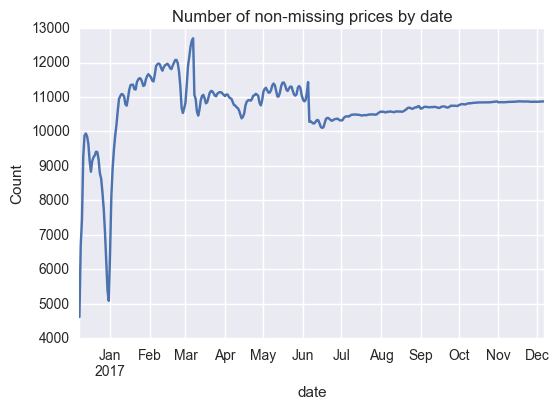

In [7]:
# Count the number of non-missing prices per day
prices = calendar.groupby('date')['price'].count()

prices.plot()
plt.title('Number of non-missing prices by date')
plt.ylabel('Count')
plt.show()

There is a sudden drop of missing price data around Christmas and NYE, with another small drop during the summer period. These are periods when more Airbnbs would be booked, so my hypothesis is that the data is missing when a property has been booked. This can be validated by plotting the number of booked Airbnbs against time.

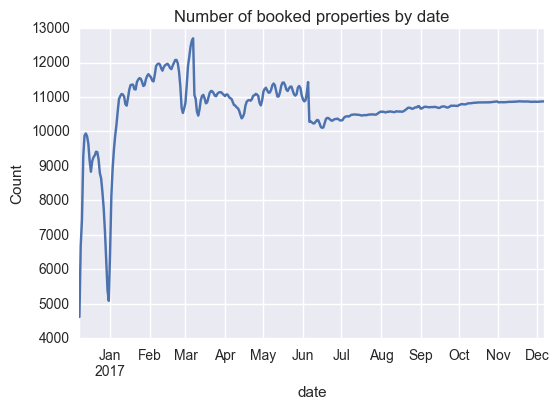

In [8]:
booked = calendar.loc[calendar.available == True].groupby('date')['price'].count()

booked.plot()
plt.title('Number of booked properties by date')
plt.ylabel('Count')
plt.show()

As expected, the line is exactly the same for number of booked properties as number of properties with missing price data. This is most likely because prices could not be scraped for these properties when they have already been booked for those dates. 

### 2.1.2 Listings

Now, I will examine the listings data, which contains a row for each Airbnb listing in Barcelona with its accompanying features

In [9]:
# Read in listings csv in pandas
listings = pd.read_csv('listings.csv', low_memory=False)

In [10]:
# Display first 5 rows
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,13639121,https://www.airbnb.com/rooms/13639121,20161208100757,2016-12-08,En el corazón de Barcelona Rbla Raval.,Mi casa esta ubicada en el corazón de Barcelon...,"En pleno corazón de Barcelona, frente a rambla...",Mi casa esta ubicada en el corazón de Barcelon...,none,NaN,...,10.0,t,NaN,NaN,f,flexible,f,f,1,2.87
1,3658011,https://www.airbnb.com/rooms/3658011,20161208100757,2016-12-08,"Center of Barcelona, 100m2 terrace & very quiet",The flat is located in Sant Antoni (between Ra...,Let me introduce you my very nice apartment ...,The flat is located in Sant Antoni (between Ra...,none,Barcelona is a city with endless possibilities...,...,9.0,t,NaN,NaN,f,flexible,f,f,2,3.12
2,9792844,https://www.airbnb.com/rooms/9792844,20161208100757,2016-12-08,"VERY CENTRIC, PERFECT FOR TOURISTS","Located in the Old City, near the famous RAMBL...","CHECK-IN is before 23:00,CHECK-OUT is at 12:00...","Located in the Old City, near the famous RAMBL...",none,"Very lively neighborhood,with a lot of restaur...",...,7.0,t,NaN,NaN,f,strict,f,f,5,1.14
3,10544538,https://www.airbnb.com/rooms/10544538,20161208100757,2016-12-08,double room in the center,"Double bedroom in the earth of the city, in th...",NaN,"Double bedroom in the earth of the city, in th...",none,The area Raval is a dynamic and characteristic...,...,9.0,t,NaN,NaN,f,flexible,f,f,1,1.42
4,440840,https://www.airbnb.com/rooms/440840,20161208100757,2016-12-08,sociable apartment in Raval 2,NaN,Welcome to the Piero's home (Italian)! The h...,Welcome to the Piero's home (Italian)! The h...,none,NaN,...,9.0,t,NaN,NaN,f,moderate,f,t,3,1.05


In [11]:
# Check all the columns and data types
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17369 entries, 0 to 17368
Data columns (total 95 columns):
id                                  17369 non-null int64
listing_url                         17369 non-null object
scrape_id                           17369 non-null int64
last_scraped                        17369 non-null object
name                                17368 non-null object
summary                             16618 non-null object
space                               12351 non-null object
description                         17367 non-null object
experiences_offered                 17369 non-null object
neighborhood_overview               9957 non-null object
notes                               7912 non-null object
transit                             9712 non-null object
access                              9539 non-null object
interaction                         8991 non-null object
house_rules                         11898 non-null object
thumbnail_url               

Listings contains 95 columns about the property, with a lot of the columns describing the different review scores and the different features of the host. For the purposes of this project, I will only look at the main features of a property, where there is not a significant amount of missing data. These columns are listed below and the dataframe is filtered using these columns.

In [12]:
# Select a subset of columns that will be used for further analysis
listings = listings[['id', 'name', 'description', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 
                     'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
                     'minimum_nights', 'maximum_nights', 'price', 'number_of_reviews', 'review_scores_rating', 
                     'instant_bookable', 'reviews_per_month']]

In [13]:
# Check column data types
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17369 entries, 0 to 17368
Data columns (total 21 columns):
id                              17369 non-null int64
name                            17368 non-null object
description                     17367 non-null object
neighbourhood_cleansed          17369 non-null object
neighbourhood_group_cleansed    17369 non-null object
zipcode                         16691 non-null object
latitude                        17369 non-null float64
longitude                       17369 non-null float64
property_type                   17369 non-null object
room_type                       17369 non-null object
accommodates                    17369 non-null int64
bathrooms                       17319 non-null float64
bedrooms                        17357 non-null float64
beds                            17339 non-null float64
minimum_nights                  17369 non-null int64
maximum_nights                  17369 non-null int64
price                     

From looking at the column types, it seems that the same problem with the price column is occuring as with the calendar dataframe. Furthermore, the instant_bookable is true or false and so can be converted to a boolean. Otherwise, all other columns have an appropriate data type. 

For convenience, I also change the names of the neighbourhood columns to remove the word 'cleansed'. 

In [14]:
# Remove the dollar sign and any thousand separators where the price is not NA
listings['price'] = listings.loc[listings.price.notnull()].price.apply(lambda x: re.sub('[$,]', '', x))

# Change the price column to numeric values
listings['price'] = pd.to_numeric(listings.price)

# Change the available column to boolean
listings['instant_bookable'] = listings['instant_bookable'].map({'t': True, 'f': False})

# Rename the neighbourhood columns to remove 'cleansed'
listings.rename(columns = {'neighbourhood_cleansed':'neighbourhood', 'neighbourhood_group_cleansed':'neighbourhood_group'}, 
                inplace = True)

listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17369 entries, 0 to 17368
Data columns (total 21 columns):
id                      17369 non-null int64
name                    17368 non-null object
description             17367 non-null object
neighbourhood           17369 non-null object
neighbourhood_group     17369 non-null object
zipcode                 16691 non-null object
latitude                17369 non-null float64
longitude               17369 non-null float64
property_type           17369 non-null object
room_type               17369 non-null object
accommodates            17369 non-null int64
bathrooms               17319 non-null float64
bedrooms                17357 non-null float64
beds                    17339 non-null float64
minimum_nights          17369 non-null int64
maximum_nights          17369 non-null int64
price                   17369 non-null float64
number_of_reviews       17369 non-null int64
review_scores_rating    14122 non-null float64
instant_bookabl

Now that I have the main features of a property, I can look at some summary statistics to describe the average property in Barcelona

In [15]:
# Obtain and display statistics for the numerical variables in listings
table = PrettyTable(['Feature', 'Average', 'Min', 'Max'])
for col in ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'price', 'number_of_reviews', 
            'review_scores_rating', 'reviews_per_month']:
    table.add_row([col, round(listings[col].mean(), 2), listings[col].min(), listings[col].max()])
print(table)

+----------------------+-----------+------+------------+
|       Feature        |  Average  | Min  |    Max     |
+----------------------+-----------+------+------------+
|     accommodates     |    3.41   |  1   |     16     |
|      bathrooms       |    1.29   | 0.0  |    8.0     |
|       bedrooms       |    1.5    | 0.0  |    10.0    |
|         beds         |    2.23   | 0.0  |    16.0    |
|    minimum_nights    |    3.2    |  1   |    365     |
|    maximum_nights    | 371740.33 |  1   | 2147483647 |
|        price         |   83.88   | 9.0  |   9120.0   |
|  number_of_reviews   |   22.35   |  0   |    380     |
| review_scores_rating |   89.32   | 20.0 |   100.0    |
|  reviews_per_month   |    1.69   | 0.02 |    10.0    |
+----------------------+-----------+------+------------+


One can see that the average listing on Airbnb is most likely an apartment, accommodating 3-4 people in 1 or 2 bedrooms. The average review rating is 89.32 which is very high, possibly indicating a bias where users are more likely to review an Airbnb when they have really enjoyed it, or severely disliked it (shown by the minimum of 20.0 rating). 

# 3. Data Visualization

## 3.1 Average Price over Time

Airbnb hosts can choose the price for their apartment for each day of the year, varying it throughout the year as demand may grow in different seasons. For example, price surges are to be expected in the spring and summer due to a growing demand of people going to Barcelona on holiday. Using the calendar data set, I can average the prices per day and plot the average price over the year period in the data set.

In [16]:
# Obtain all dates from the calendar data
dates = sorted(calendar.date.unique())

In [17]:
# Calculate the average price of listings for each day
prices = calendar.groupby('date')['price'].mean().tolist()

In [18]:
# Split the Airbnb listings by neighbourhood
hood_listings = defaultdict()
for hood in listings.neighbourhood_group.unique():
    hood_listings[hood] = list(listings.loc[listings.neighbourhood_group==hood].id.unique())

In [19]:
# Stratify the average prices by date and neighbourhood to examine individual trends
hood_prices = defaultdict()
for hood in listings.neighbourhood_group.unique():
    hood_prices[hood] = calendar.loc[calendar.listing_id.isin(hood_listings[hood])].groupby('date')['price'].mean().tolist()

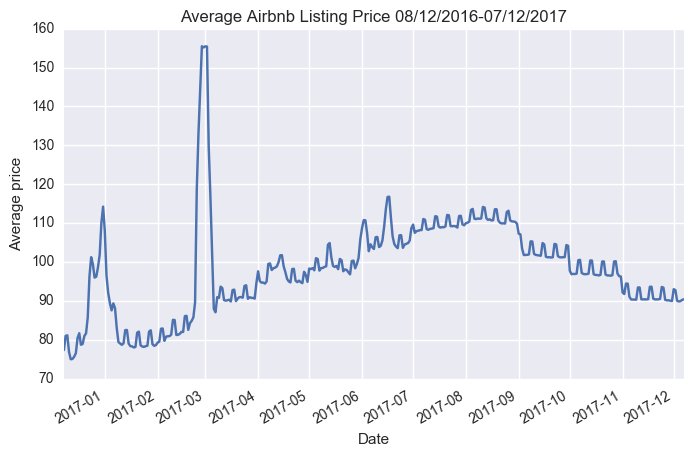

In [20]:
# Plot temporal trend of prices
months = MonthLocator()
days = DayLocator()
monthsFmt = DateFormatter('%Y-%m')
fig, axs = plt.subplots(1, 1)
plt.plot(dates, prices, '-')
axs.xaxis.set_major_locator(months)
axs.xaxis.set_major_formatter(monthsFmt)
axs.xaxis.set_minor_locator(days)
axs.autoscale_view()
axs.fmt_xdata = DateFormatter('%Y-%m-%d')
axs.grid(True)
axs.set_ylabel('Average price')
axs.set_xlabel('Date')
axs.set_title('Average Airbnb Listing Price 08/12/2016-07/12/2017')

fig.adjustable = True
fig.set_size_inches(8, 5) 
fig.autofmt_xdate()
plt.show()

Looking at the general trend, the prices tend to go up from the start of the year and peak around August time, when most tourists come to Barcelona. The price then dips again from September to the end of the year. Some very noticeable peaks however, are the peak around Christmas and New Years Eve which bumps the price up to between 100-120 dollars a night. More shocking however, is the peak happening around end of February to beginning of March. I'll plot just this period to have a closer look.

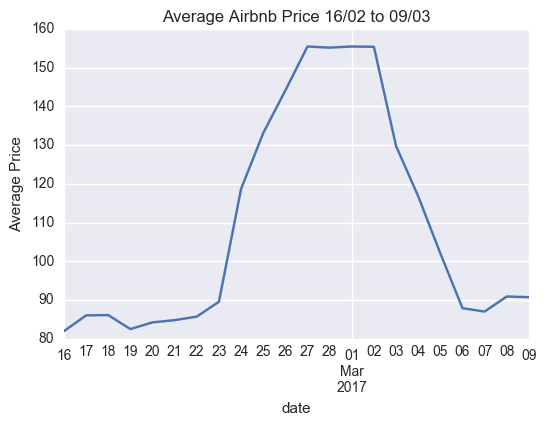

In [21]:
# Select prices between 15/02/2017 and 10/03/2017, calculating the average price per day
calendar.loc[(calendar.date>'2017-02-15') & (calendar.date<'2017-03-10')].groupby('date')['price'].mean().plot()
plt.ylabel('Average Price')
plt.title('Average Airbnb Price 16/02 to 09/03')
plt.show()

The average price seems to peak from the 27/02 to the 02/03, corresponding to the 2017 <a href="https://www.mobileworldcongress.com/">Mobile World Congress</a> hosted in Barcelona, the world's largest gathering for the mobile industry.

Barcelona is a large city and it may be that different neighbourhoods of the city are affected differently by seasonal price changes. I can plot the average prices by neighbourhood and evaluate the independent trends.

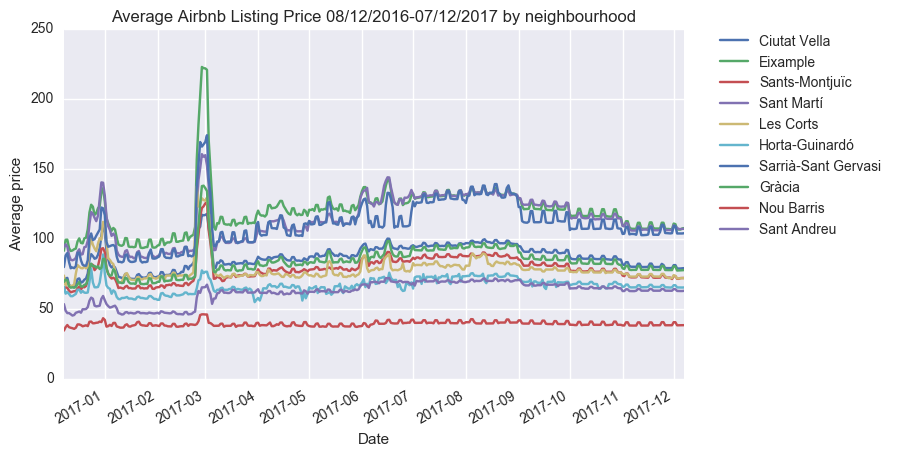

In [22]:
months = MonthLocator()
days = DayLocator()
monthsFmt = DateFormatter('%Y-%m')
fig, axs = plt.subplots(1, 1)
for hood in listings.neighbourhood_group.unique():
    plt.plot(dates, hood_prices[hood], '-', label=hood)
axs.xaxis.set_major_locator(months)
axs.xaxis.set_major_formatter(monthsFmt)
axs.xaxis.set_minor_locator(days)
axs.autoscale_view()
axs.fmt_xdata = DateFormatter('%Y-%m-%d')
axs.grid(True)
axs.set_ylabel('Average price')
axs.set_xlabel('Date')
axs.set_title('Average Airbnb Listing Price 08/12/2016-07/12/2017 by neighbourhood')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.adjustable = True
fig.set_size_inches(8, 5) 
fig.autofmt_xdate()
plt.show()

It does not seem that neighbourhoods have differing trends. The bottom red line corresponds to 'Nou Barris' which is a neighbourhood in Barcelona that is quite far from the city center, thus offers much cheaper accommodation all year round. The spike due to the Mobile World Congress was higher in certain neighbourhoods, likely due to their proximity to the event.

## 3.2 Map Visualization of Airbnbs

Section 3.1 looked at the temporal trends in price for Airbnb listings. However, I also wish to understand the spatial factors that could influence price, for example the proximity to city centre and/or beach. To do so, I plot the statistics for each neighbourhood on their location in a map of Barcelona. Below, the size of the marker indicates the average price per person of listings in a neighbourhood, and the intensity of the colour indicates the number of listings in that area. Markers are interactive and can be clicked on to see the exact statistics of the neighbourhood.

In [23]:
# Standardizing the price of listings per person that it accommodates
listings['priceperperson'] = listings.apply(lambda x: x['price']/x['accommodates'], axis=1)

In [24]:
# Find the mean characteristics of neighbourhoods, lat and lon for plotting and the mean price
neighbourhoods = listings.groupby('neighbourhood')['latitude','longitude','priceperperson'].mean()

In [25]:
# Add the number of listings to each neighbourhood
neighbourhoods['count'] = listings.groupby('neighbourhood')['id'].count()

In [26]:
def colour(count):
    '''
    Input: Takes in the number of listings for a neighbourhood
    Output: Returns the appropriate colour for the plot
    '''
    if count<=100:
        return '#ffc2b3'
    elif count<=250:
        return '#ff8566'
    elif count<=500:
        return '#ff3300'
    else:
        return '#b32400'

In [27]:
# Draw a map of Barcelona
map_osm = folium.Map(location=[41.3887, 2.1724], zoom_start=13)

# Add the markers on top with radius indicating price and colour the density of listings
for hood in neighbourhoods.index:
    folium.CircleMarker(
        location=[neighbourhoods.loc[hood, 'latitude'], neighbourhoods.loc[hood, 'longitude']],
        radius=neighbourhoods.loc[hood,'priceperperson'],
        popup='{} | Average Price: ${:.2f} | Listings: {:.0f}'.format(hood,neighbourhoods.loc[hood,'priceperperson'],neighbourhoods.loc[hood, 'count']),
        color=colour(neighbourhoods.loc[hood, 'count']),
        fill_color=colour(neighbourhoods.loc[hood, 'count'])
    ).add_to(map_osm)

In [28]:
map_osm

The number of listings in Barcelona is most dense near the centre of Barcelona, surrounding the Gothic Quarter and Old Town. There is also a high concentration near to the sea, but as one moves further into the peripheries, the number of listings drops quickly. This is unsurprising given that tourists would want to be as central as possible. However, looking at only prices, there are clearly some neighbourhoods that have high prices regardless of their location. This is the case for 'Diagonal Mar' and 'la Vila Olimpica' where the average price is \$39.43 and \$31.50 per person per night respectively, due to their proximity to the sea. 'Les Tres Torres' and 'Pedralbes' have the highest average prices per person, due to them being the "upper-class" neighbourhoods of Barcelona.

# 4. Modelling the Price 

In this section, I will create a regression model to try to predict listing price based on the features in our data. I will test and compare a linear Regression, Ridge Regression and Random Forest Regressor.

Some preprocessing steps are carried out before the models can be fitted with the data. First, I impute missing values into the columns where missing values are present. A median imputation strategy is used because it is more robust to outliers than using the mean. Following this, the numerical features are min-max scaled to have scale invariant features, leading to better model coefficients. Finally, the categorical variables are split into dummy variables which makes the total number of features in our model 92. The data is split into train and test (80/20 split) so the models can be validated on unseen test data. 

Since the price of listings is a heavy tailed variable, and always must be positive, the response variable taken for the regression models is ln(price). That means the final predictions will be $\text{exp}(x)$ where $x$ is the output model predictions.

In [31]:
# Removing an anomaly data point where price per night is 9120
listings.drop(listings.loc[listings.price>8000].index, inplace=True)

In [32]:
features = ['neighbourhood', 'neighbourhood_group', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 
            'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'instant_bookable']
categorical = ['neighbourhood', 'neighbourhood_group', 'room_type']
numerical = ['accommodates', 'bathrooms', 'bedrooms', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating']

X = listings[features]
y = np.log(listings['price'])

# Need to impute values for bathrooms, bedrooms and review_scores_rating
print('Imputing Missing Values...')
Imp = Imputer(strategy='median')
X.loc[:,['bathrooms', 'bedrooms', 'review_scores_rating']] = Imp.fit_transform(X.loc[:, ['bathrooms', 'bedrooms', 'review_scores_rating']])

# d = defaultdict(LabelEncoder)
# X[categorical] = X[categorical].apply(lambda x: d[x.name].fit_transform(x))

print('Scaling Numerical Variables...')
d = defaultdict(MinMaxScaler)
X.loc[:, numerical] = X.loc[:, numerical].apply(lambda x: d[x.name].fit_transform(x))

print('Creating Dummy Variables...')
X = pd.get_dummies(X, columns=categorical)

print('Splitting Data into Train/Test...')
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, random_state=1994)

print('Fit Linear Regression...')
lm = LinearRegression()
lm.fit(train_X, train_Y)

print('Fit Ridge Regression...')
ridge = Ridge()
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
gs = GridSearchCV(ridge, param_grid)
gs.fit(train_X, train_Y)
ridge = gs.best_estimator_
ridge.fit(train_X, train_Y)

print('Fit Random Forest...')
rf = RandomForestRegressor(n_estimators=1000, max_depth=16, min_samples_leaf=3)

# ----------CROSS-VALIDATION FOR HYPERPARAMETER OPTIMIZATION TAKES LONG - EXECUTE AT RISK-----------
# param_grid = {'n_estimators': [10, 100, 1000], 'max_depth': [2, 4, 8, 16], 'min_samples_leaf': [1, 2, 3]}
# gs = GridSearchCV(rf, param_grid)
# gs.fit(train_X, train_Y)
# rf = gs.best_estimator_
# ---------------------------------------------------------------------------------------------------
rf.fit(train_X, train_Y)

Imputing Missing Values...
Scaling Numerical Variables...
Creating Dummy Variables...
Splitting Data into Train/Test...
Fit Linear Regression...
Fit Ridge Regression...
Fit Random Forest...


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [33]:
# Obtain predictions and scores on the test set
ridge_pred = ridge.predict(test_X)
ridge_score = r2_score(np.exp(test_Y), np.exp(ridge_pred))

lm_pred = lm.predict(test_X)
lm_score = r2_score(np.exp(test_Y), np.exp(lm_pred))

rf_pred = rf.predict(test_X)
rf_score = r2_score(np.exp(test_Y), np.exp(rf_pred))

In [34]:
# Display results on the test set
results = PrettyTable(['Model', 'R2 Score'])
results.add_row(['Linear Regression', round(lm_score, 4)])
results.add_row(['Ridge Regression', round(ridge_score, 4)])
results.add_row(['Random Forest', round(rf_score, 4)])
print(results)

+-------------------+----------+
|       Model       | R2 Score |
+-------------------+----------+
| Linear Regression |  0.4429  |
|  Ridge Regression |  0.4374  |
|   Random Forest   |  0.514   |
+-------------------+----------+


The metric of choice to evaluate the models is R2 score which is higher when the model can better explain the variability in the response variable. It is clear that all three models outperform the benchmark of predicting the average listing price for every property (R2 score of 0.0), and Random Forest reaches 0.51 R2 score meaning it explains 51% of the price variation. To try and improve this, more feature engineering could be performed and alternative models explored such as Gradient Boosted Trees or Neural Networks. 

Random Forest models in sklearn provides the functionality to look at feature importances, which explains the factors that most explain the price variation. Below is a table containing the top 10 feature importances:

In [35]:
# Match the feature importances with the column names and pick out the top 10
feat_imp = [(x,y) for x,y in zip(X.columns, rf.feature_importances_)]
feat_imp = sorted(feat_imp, key=lambda x: x[1], reverse=True)[:10]

In [36]:
# Display the top 10 feature importances
features = PrettyTable(['Feature', 'Importance Score'])
for feat, imp in feat_imp:
    features.add_row([feat,round(imp, 4)])
print(features)

+--------------------------------------+------------------+
|               Feature                | Importance Score |
+--------------------------------------+------------------+
|      room_type_Entire home/apt       |      0.6012      |
|              bathrooms               |      0.094       |
|               latitude               |      0.0707      |
|              longitude               |      0.0582      |
|             accommodates             |      0.0493      |
|          number_of_reviews           |      0.0472      |
|         review_scores_rating         |      0.0278      |
|               bedrooms               |      0.0085      |
| neighbourhood_la Dreta de l'Eixample |      0.0078      |
|           instant_bookable           |      0.0057      |
+--------------------------------------+------------------+


By far the most important feature as shown by the Random Forest Model is whether a host is listing the entire home/apt. This indicates that there is a significant price discrepancy between listings which are a private/shared room, versus the whole property. The number of bathrooms and the location of the apartment seem to also have a significant effect on the price.

# 5. Conclusions

In this project, I aimed to understand which factors impact the price for Airbnbs in Barcelona. A combination of data visualizations and modelling returned some conclusive results surrounding this question. Firstly, there is a temporal trend in price, with public holidays and summer forcing Airbnb listing prices up. Furthermore, one-off big events such as the Mobile World Congress increase prices due to the immediate demand surge. Secondly, there seemed to be a spatial trend in prices, shown by the map visualization and the model. Listings near the beach or in good neighbourhoods tended to have higher average prices per person. However, while central neighbourhoods have many more listings, it is interesting that they do not have high prices compared to other neighbourhoods. Lastly, the model showed that listing the entire home vs a private room explains a lot of the variance in price. 

There are certain limitations to the analysis which could have had an effect on the overall results. The first is that there is no price data in the calendar dataset for listings that have been booked. There is a possibility that the lack of Airbnbs to book could push the prices up, but the average price paid by all customers who have previously booked is not higher than other seasons. Second, there are several spam listings on Airbnb such as <a href="https://es.airbnb.com/rooms/13722943#host-profile">this</a> one which have abnormally high prices for one small room. Listings like this distort the data by introducing false dependencies between factors and high prices, affecting the overall results. Lastly, there are certain parameters that are unobservable by our data, such as the overall quality and decoration of the apartment, which a human would factor into deciding a listing price.

Future work for this project could include creating more sophisticated models for regression analysis, and also including listing images into our model as features. This could be implemented into a web app for new hosts to use when deciding the price of a new listing.  